## Imports and Settings

In [1]:
import json
from datetime import datetime, time, timedelta
import os
from Powerfleet_APIs_Management import PowerFleetAPIsManager as ApiManager
from colorama import Fore, Style, init
import sys  # For printing caught exceptions
import re
from Powerfleet_APIs_Management import MongoDBConnector as DBConnector
from pathlib import Path
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geopandas as gpd
import math
from typing import *
import statistics
import matplotlib.cm as cm
import seaborn as sns
# from geojson_creator import GeoJSONCreator, VehicleGeoJSONCreator
from typing import Dict
import ast
import requests
from pymongo import MongoClient, errors
from bson.json_util import dumps
from scipy.spatial import ConvexHull
from geopy.distance import geodesic
from shapely.geometry import Point


### Flags & Settings

#### Enable plot UI backend

In [2]:
# %matplotlib tk

#### ** Skip** API calls and inits

In [3]:
PLOT_FOLDER_PATH = "./Plots/"


# Flags
FETCH_FROM_DB = False

## Update <u>PARAMETERS.json</u> with **current** date and time

In [4]:
if FETCH_FROM_DB:
    """
    This block handles the process of loading and updating a JSON file ('PARAMETERS.json') by adding the current date and time 
    to the 'endDate' field in the 'snapshot_api' section. It performs file existence and size checks, as well as error handling 
    for loading and saving the file.
    """
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    file_path = "PARAMETERS.json" 

    # Get the current date and time
    current_datetime = datetime.now().strftime("%Y-%m-%d")  # Format as YYYY-MM-DD
    current_time = datetime.now().strftime("%H:%M:%S")  # Format as HH:MM:SS

    # Check if the file exists and is not empty
    if not os.path.exists(file_path):
        print(f"Error: The file '{file_path}' does not exist.")
        exit()

    # Check if the file is empty
    if os.path.getsize(file_path) == 0:
        print(f"Error: The file '{file_path}' is empty.")
        exit()

    # Load the current JSON data
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON. Details: {e}")
        exit()

    # Combine the date and time
    combined_datetime = current_datetime + " " + current_time

    # Update the 'endDate' field in the 'snapshot_api' section
    data["snapshot_api"]["endDate"] = combined_datetime

    # Save the updated JSON data back to the file
    try:
        with open(file_path, "w") as file:
            json.dump(data, file, indent=4)  # Use indent for readable JSON formatting
        print(f"Updated PARAMETERS.json with: {combined_datetime}.")
    except Exception as e:
        print(f"Error: Failed to save the updated file. Details: {e}")


Updated PARAMETERS.json with: 2025-05-03 17:53:21.


## Fetch from DB

In [5]:
if FETCH_FROM_DB:  # *Fetch from DB
    """
    Connects to a MongoDB database and fetches all documents from a specified collection.
    Converts the fetched documents into a pandas DataFrame and drops the default '_id' column.
    
    Raises exceptions if there is an issue with connecting to MongoDB or fetching data.
    """
    try:
        # Connect to MongoDB
        client = MongoClient("mongodb://localhost:27017/", serverSelectionTimeoutMS=5000)  # 5s timeout
        db = client["Ptyxiaki"]
        collection = db["Powerfleet GPS"]

        # Test connection
        client.server_info()  # *Raises an error if connection fails

        # Fetch all documents from the collection
        cursor = collection.find()

        # Convert to a DataFrame
        merged_dfs = pd.DataFrame(list(cursor))

        # *Drop MongoDB's default '_id' column 
        if "_id" in merged_dfs.columns:
            merged_dfs.drop(columns=["_id"], inplace=True)
        
        # Display the DataFrame
        print(Fore.GREEN + "Data Fetched Successfully" + Style.RESET_ALL)
        print(merged_dfs.head())

    except errors.ServerSelectionTimeoutError:
        print("Error: Unable to connect to MongoDB. Check if the server is running.", file=sys.stderr)
        merged_dfs = None
    except errors.ConnectionFailure:
        print("Error: Connection to MongoDB failed.", file=sys.stderr)
        merged_dfs = None
    except Exception as e:
        print(f"Unexpected Error: {e}", file=sys.stderr)
        merged_dfs = None
else:
    print(Fore.YELLOW + "Cell Skipped" + Style.RESET_ALL)


Cell Skipped


## Ready variables for APIs usage

In [6]:
if FETCH_FROM_DB:
    """
    Skips the execution of the cell if the FETCH_FROM_DB flag is set. Otherwise, it prints the current working directory 
    (CWD) and lists the contents of the directory. It also defines the ApiParameterExtractor class to read and extract 
    API parameters from a JSON file, and uses these extracted parameters to instantiate API managers.
    """
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    print(Fore.YELLOW + f"MAIN CWD={os.getcwd()}")
    print(f"MAIN, LISTDIR={os.listdir()}" + Style.RESET_ALL)

    # Define the ApiParameterExtractor class
    class ApiParameterExtractor:
        """
        Class to extract API parameters from a given JSON file based on API type.
        
        :param json_file: Path to the JSON file containing the parameters.
        """
        def __init__(self, json_file):
            with open(json_file, 'r') as file:
                self.parameters = json.load(file)

        def extract_parameters(self, api_type):
            """
            Extract parameters for a specified API type ('live_api' or 'snapshot_api').

            :param api_type: The type of API to extract parameters for.
            :return: Dictionary containing parameters for the given API type.
            """
            # Normalize API type to lowercase
            api_type = api_type.lower()
            
            # Validate API type
            if api_type not in self.parameters:
                raise ValueError(f"Invalid API type: {api_type}. Valid types are 'live_api' or 'snapshot_api'.")
            
            # Return the corresponding dictionary for the given API type
            return self.parameters[api_type]

    extractor = ApiParameterExtractor("PARAMETERS.json")

    # Extract parameters for live_api and snapshot_api
    live_api_params         = extractor.extract_parameters("live_api")
    snapshot_api_params     = extractor.extract_parameters("snapshot_api")

    # Pass the extracted parameters to PowerFleetAPIsManager
    live_api_manager        = ApiManager(live_api_params)
    snapshot_api_manager    = ApiManager(snapshot_api_params)


MAIN CWD=/home/georger/WorkDocuments/Sxoli/Ptyxiaki/Ptyxiaki-Repository/Python_Scripts/Data_Analysis
MAIN, LISTDIR=['Powerfleet_APIs_Management.py', 'projection_to_streets.ipynb', 'geojson_creator.py', 'visualize_dangers.csv', 'visualize_danger_areas_v1.ipynb', '.ipynb_checkpoints', 'projection_to_streetsv2.ipynb', 'single_data_analysis.ipynb', 'all_vehicles_tripoli_data_processed.csv', 'all_vehicle_responses_with_projections.csv', 'Plots', 'PARAMETERS.json', '__pycache__', 'all_data_analysis.ipynb']


## Fetch Live & Snapshot APIs

In [7]:
if FETCH_FROM_DB:
    """
    Skips the execution of the cell if the FETCH_FROM_DB flag is set. Otherwise, it defines functions for saving 
    DataFrames to CSV, converting UNIX timestamps to human-readable datetimes, and merging DataFrames. It also 
    loads API parameters from a JSON file and fetches and processes vehicle data for each vehicleId in a loop, 
    appending the results to a combined DataFrame.
    """
    print(Fore.YELLOW + "Cell skipped" + Style.RESET_ALL) 
else:
    # === Function to Save DataFrame to CSV ===
    def save_to_csv(dataframe, output_dir, file_name):
        """
        Save a DataFrame to a specified CSV file in the given directory.
        
        :param dataframe: The DataFrame to save.
        :param output_dir: The directory where the CSV file will be saved.
        :param file_name: The name of the CSV file (e.g., "file_name.csv").
        """
        if not dataframe.empty:  # Only save if the DataFrame is not empty
            os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
            file_path = Path(output_dir) / file_name  # Construct the full file path
            dataframe.to_csv(file_path, index=False)  # Overwrite the CSV file by default
            print(f"Data saved to {file_path}")
        else:
            print(f"No data to save for {file_name}. Skipping...")

    # === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
    def unix_to_datetime_pandas(dataframe, column_name):
        """
        Convert a UNIX timestamp column to human-readable datetime format.
        
        :param dataframe: The DataFrame containing the column.
        :param column_name: The column name containing UNIX timestamps.
        """
        if column_name in dataframe.columns:
            try:
                dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
                print(f"Converted '{column_name}' to human-readable datetime.")
            except Exception as e:
                print(f"Error converting column '{column_name}': {e}")
        else:
            print(f"Column '{column_name}' not found in DataFrame.")


    def merge_merged_dfs(ALL_merged_dfsS):
        """
        Merge a list of DataFrames into a single DataFrame.
        
        :param ALL_merged_dfsS: List of DataFrames to be merged.
        :return: A single merged DataFrame.
        """
        result = pd.concat(ALL_merged_dfsS, ignore_index=True)
        print(type(result))
        return result
        
        
    # === Constants ===
    target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"

    # === Step 3: Load Parameters from JSON File ===
    with open("PARAMETERS.json", "r") as file:
        PARAMETERS = json.load(file)  # Load API parameters from the JSON file

    # === Step 4: Loop to Fetch and Append Data for Each Vehicle ===
    _cnt = 1  # Counter for vehicle IDs
    snapshot_data = None  # Initialize snapshot_data to enter the loop


    ALL_merged_dfsS = []

    while _cnt <= 20:  # Run for up to 100 times
        # Update the vehicleId in PARAMETERS
        PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
        
        # Extract updated vehicleId and fetch snapshot data
        vehicleId = PARAMETERS["snapshot_api"]["vehicleId"]
        startDate = PARAMETERS["snapshot_api"]["startDate"]
        endDate = PARAMETERS["snapshot_api"]["endDate"]
        
        # Fetch snapshot data (Returns JSON)
        snapshot_data = snapshot_api_manager.get_snapshot_data(vehicleId, startDate, endDate)
        
        # Skip if no data is found (None or empty data)
        if not snapshot_data:
            print(f"No data found for vehicleId {vehicleId}. Skipping...")
            _cnt += 1
            continue
        
        # Parse the JSON snapshot data into a DataFrame
        try:
            # If the snapshot data is a valid JSON string, parse it
            snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
            
            # Handle JSON structure (either dict or list)
            if isinstance(snapshot_data_dict, dict):
                snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
            elif isinstance(snapshot_data_dict, list):
                snapshot_data_list = snapshot_data_dict  # Already a list of dicts
            else:
                snapshot_data_list = []
            
            # Create a DataFrame from the list of dictionaries
            snapshot_merged_dfs = pd.DataFrame(snapshot_data_list)
                
            ALL_merged_dfsS.append(snapshot_merged_dfs)
            #save_to_csv(snapshot_merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", f"Vehicle_{_cnt}_response.csv")

            
            
        
        except json.JSONDecodeError as e:
            print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

        # Increment the vehicleId counter
        _cnt += 1
        

    merged_dfs = merge_merged_dfs(ALL_merged_dfsS)
    print(type(merged_dfs))
        
    # # Save the DataFrame to CSV only if it's not empty
    # save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")


    # print("Process complete!")


**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!


# **Filter only Tripoli's BBOX**


In [8]:
"""
Filters the `merged_dfs` DataFrame to retain only rows within a defined bounding box
(Tripoli area) and reports the number of rows and any missing vehicle IDs (expected 1–20).

Prints row counts before and after filtering, and lists any vehicle IDs that were not retained.
"""


init(autoreset=True)

# Print initial row count
print(Fore.GREEN + f"Before filtering: {len(merged_dfs)} total rows")

# Define expected vehicle IDs (1 through 20)
expected_ids = set(range(1, 21))

# Define bounding box coordinates
tripoli_bbox = {
    'latMin': 37.49764419371479,
    'latMax': 37.56244081620044,
    'lngMin': 22.344992459074458,
    'lngMax': 22.521463853839485
}

# Filter the rows that are within the bounding box
merged_dfs = merged_dfs[
    (merged_dfs['lat'] >= tripoli_bbox['latMin']) & 
    (merged_dfs['lat'] <= tripoli_bbox['latMax']) &
    (merged_dfs['lng'] >= tripoli_bbox['lngMin']) & 
    (merged_dfs['lng'] <= tripoli_bbox['lngMax'])
]

# Get actual IDs after filtering
actual_ids = set(merged_dfs['vehicleId'])
missing_ids = expected_ids - actual_ids

# Output filtered results
print(Fore.YELLOW + f"After filtering: {len(merged_dfs)} total rows")
print(Fore.YELLOW + f"Vehicle IDs missing from filtered data: {sorted(missing_ids)}")


Before filtering: 62838 total rows
After filtering: 29032 total rows
Vehicle IDs missing from filtered data: [2, 3, 6, 10, 14, 16, 17, 18]


In [9]:
expected_ids = set(range(1, 21))  # IDs from 1 to 20
actual_ids = set(merged_dfs['vehicleId'])
missing_ids = expected_ids - actual_ids
print("Missing IDs:", missing_ids)


Missing IDs: {2, 3, 6, 10, 14, 16, 17, 18}


## Visualize data **dispersion**

### Plot number of data lines of each vehicle

**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!
**Snapshot API**
Snapshot API Request Successful!


/tmp/ipykernel_9889/2893324062.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_vehicles)(range(num_vehicles))  # Generate distinct colors for each vehicle


Plot saved to ./Plots/vehicle_rows_per_id.png


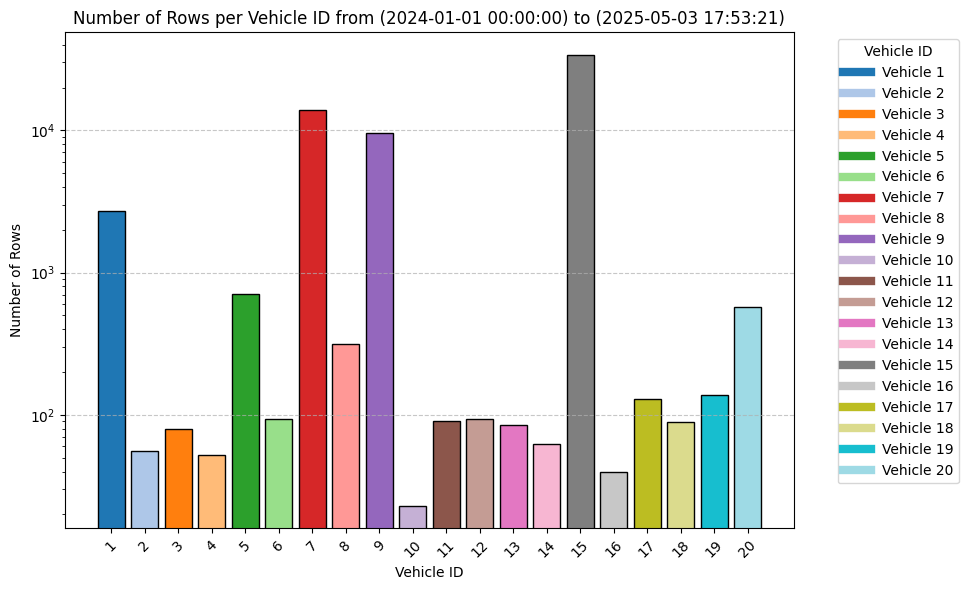

Process complete!


In [10]:
# === Function to Save DataFrame to CSV ===
def save_to_csv(dataframe, output_dir, file_name):
    """
    Save a DataFrame to a specified CSV file in the given directory.
    
    :param dataframe: The DataFrame to save.
    :param output_dir: The directory where the CSV file will be saved.
    :param file_name: The name of the CSV file (e.g., "file_name.csv").
    """
    if not dataframe.empty:  # Only save if the DataFrame is not empty
        os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
        file_path = Path(output_dir) / file_name  # Construct the full file path
        dataframe.to_csv(file_path, index=False)  # Overwrite the CSV file by default
        print(f"Data saved to {file_path}")
    else:
        print(f"No data to save for {file_name}. Skipping...")

# === Function to Convert UNIX Timestamps to Datetime Using Pandas ===
def unix_to_datetime_pandas(dataframe, column_name):
    """
    Convert a UNIX timestamp column to human-readable datetime format.
    
    :param dataframe: The DataFrame containing the column.
    :param column_name: The column name containing UNIX timestamps.
    """
    if column_name in dataframe.columns:
        try:
            dataframe[column_name] = pd.to_datetime(dataframe[column_name] / 1000, unit='s')  # Convert from ms to seconds
            print(f"Converted '{column_name}' to human-readable datetime.")
        except Exception as e:
            print(f"Error converting column '{column_name}': {e}")
    else:
        print(f"Column '{column_name}' not found in DataFrame.")


def merge_merged_dfs(ALL_merged_dfsS):
    """
    Merge multiple DataFrames into one single DataFrame.

    :param ALL_merged_dfsS: List of DataFrames to merge.
    :return: A single merged DataFrame containing all rows from the input DataFrames.
    """
    result = pd.concat(ALL_merged_dfsS, ignore_index=True)
    print(type(result))
    return result
    
    
# === Constants ===
target_file = "../../DataSets/API_Responses/Vehicle_Data/Every_vehicle_response.csv"
# snapshot_csv_path = "../../DataSets/API_Responses/Snapshot_API_Response_data_set.csv"  # Modify with your source CSV path

# === Step 1: Load Parameters from JSON File ===
with open("PARAMETERS.json", "r") as file:
    PARAMETERS = json.load(file)  # Load API parameters from the JSON file

# === Step 2: Loop to Fetch and Append Data for Each Vehicle ===
_cnt = 1  # Counter for vehicle IDs
snapshot_data = None  # Initialize snapshot_data to enter the loop

ALL_merged_dfsS = []

while _cnt <= 20:  # Run for up to 100 times
    # Update the vehicleId in PARAMETERS
    PARAMETERS["snapshot_api"]["vehicleId"] = str(_cnt)
    
    # Fetch snapshot data (Returns JSON)
    snapshot_data = snapshot_api_manager.get_snapshot_data(str(_cnt), PARAMETERS["snapshot_api"]["startDate"], PARAMETERS["snapshot_api"]["endDate"])
    
    # Skip if no data is found (None or empty data)
    if not snapshot_data:
        print(f"No data found for vehicleId {str(_cnt)}. Skipping...")
        _cnt += 1
        continue
    
    # Parse the JSON snapshot data into a DataFrame
    try:
        snapshot_data_dict = json.loads(snapshot_data) if isinstance(snapshot_data, str) else snapshot_data
        
        if isinstance(snapshot_data_dict, dict):
            snapshot_data_list = [snapshot_data_dict]  # Convert single dict to list of dicts
        elif isinstance(snapshot_data_dict, list):
            snapshot_data_list = snapshot_data_dict  # Already a list of dicts
        else:
            snapshot_data_list = []
        
        snapshot_merged_dfs = pd.DataFrame(snapshot_data_list)
        ALL_merged_dfsS.append(snapshot_merged_dfs)
        
    except json.JSONDecodeError as e:
        print(f"Error decoding snapshot JSON for vehicleId {_cnt}: {e}")

    # Increment the vehicleId counter
    _cnt += 1
    

# Merge all DataFrames
merged_dfs = merge_merged_dfs(ALL_merged_dfsS)
print(type(merged_dfs))
    
# Save the DataFrame to CSV only if it's not empty
save_to_csv(merged_dfs, "../../DataSets/API_Responses/Vehicle_Data", "all_vehicle_responses.csv")

# === Step 3: Filtering Data within Bounding Box for Tripoli ===
print(Fore.GREEN + f"Before filtering: {len(merged_dfs)} total rows")

# Define bounding box coordinates for Tripoli
tripoli_bbox = {
    'latMin': 37.49764419371479,
    'latMax': 37.56244081620044,
    'lngMin': 22.344992459074458,
    'lngMax': 22.521463853839485
}

# Filter the rows that are within the bounding box
merged_dfs = merged_dfs[(merged_dfs['lat'] >= tripoli_bbox['latMin']) & 
                        (merged_dfs['lat'] <= tripoli_bbox['latMax']) &
                        (merged_dfs['lng'] >= tripoli_bbox['lngMin']) & 
                        (merged_dfs['lng'] <= tripoli_bbox['lngMax'])]

print(f"After filtering: {len(merged_dfs)} total rows" + Style.RESET_ALL)

# === Step 4: Collect Unique Vehicle IDs and Rows Count ===
unique_veh_ids = []
vehicle_rows = []

# Ensure there is data to process
if not ALL_merged_dfsS:
    print("No data found to process!")
else:
    # Iterate over the list of all merged DataFrames
    for individual_df in ALL_merged_dfsS:
        if not individual_df.empty and 'vehicleId' in individual_df.columns:
            unique_veh_ids.append(individual_df['vehicleId'].values[0])  # Extract the vehicle ID
            vehicle_rows.append(len(individual_df))  # Count the number of rows in the DataFrame
        else:
            print(f"Warning: DataFrame is empty or 'vehicleId' column is missing.")

    # If there is valid data, proceed with the plot
    if unique_veh_ids and vehicle_rows:
        # Debugging: Print the number of rows for each vehicle
        for vehicle_id, rows in zip(unique_veh_ids, vehicle_rows):
            print(f"Vehicle ID {vehicle_id}: {rows} rows")

        # Generate a colormap
        num_vehicles = len(unique_veh_ids)
        colors = cm.get_cmap('tab20', num_vehicles)(range(num_vehicles))  # Generate distinct colors for each vehicle

        # Create a bar plot
        plt.figure(figsize=(10, 6))
        bars = plt.bar(unique_veh_ids, vehicle_rows, color=colors, edgecolor='black')  # Assign colors to bars

        # Add a legend for the bar colors
        legend_handles = [plt.Line2D([0], [0], color=color, lw=6, label=f'Vehicle {vehicle_id}') 
                            for color, vehicle_id in zip(colors, unique_veh_ids)]
        plt.legend(handles=legend_handles, title="Vehicle ID", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Customize plot
        plt.xlabel('Vehicle ID')
        plt.ylabel('Number of Rows')
        plt.title(f'Number of Rows per Vehicle ID from ({PARAMETERS["snapshot_api"]["startDate"]}) to ({PARAMETERS["snapshot_api"]["endDate"]})')
        plt.xticks(unique_veh_ids, rotation=45)
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Set a logarithmic scale for better visualization of large variations
        plt.yscale("log")

        # Define the path to save the plot
        plot_save_path = os.path.join(PLOT_FOLDER_PATH, "vehicle_rows_per_id.png")

        # Save the plot
        plt.savefig(plot_save_path, bbox_inches='tight')
        print(f"Plot saved to {plot_save_path}")

        # Show the plot (optional, can be removed if not needed)
        plt.show()
    else:
        print("No valid vehicle data to plot!")

print("Process complete!")


### Create 2 columns for datetime readable for Humans and for time alone & Sort by dateStored for more accracy


In [11]:
"""
This cell processes and enriches the `merged_dfs` DataFrame by performing the following steps:

1. Converts the 'dateStored' UNIX timestamp column (in milliseconds) to a human-readable datetime format.
2. Extracts and adds:
    - 'dateOnlyStoredHuman': the date portion (YYYY-MM-DD) from the converted datetime.
    - 'timeOnly': the time portion (HH:MM:SS) from the converted datetime.
3. Sorts the DataFrame in ascending order by the original 'dateStored' timestamp.
4. Extracts columns of interest:
    - 'lat' as `lat_clmn`
    - 'lng' as `long_clmn`
    - 'dateStored' as `date_stored`
5. Optionally includes a line (commented) to drop the temporary datetime columns if not needed.
6. Displays the first few rows of the updated DataFrame for verification.
"""


# Convert the 'dateStored' column to datetime format
merged_dfs['dateStoredHuman']           = merged_dfs['dateStored'].apply(lambda x: datetime.fromtimestamp(x / 1000))
merged_dfs['dateOnlyStoredHuman']       = merged_dfs['dateStoredHuman'].dt.date  # Extract the date only
merged_dfs['timeOnly']                  = merged_dfs['dateStoredHuman'].dt.time  # Extract the time only

#! Sort the DataFrame by 'dateStored' in ascending order
merged_dfs                              = merged_dfs.sort_values(by='dateStored', ascending=True)

# Extract columns of interest
lat_clmn                                = merged_dfs['lat']
long_clmn                               = merged_dfs['lng']
date_stored                             = merged_dfs['dateStored']

# #! Drop temp columns
# merged_dfs = merged_dfs.drop(columns=['dateStoredHuman'])



print(merged_dfs.head())

    vehicleId        lat        lng     dateStored  velocity  odometer  \
89          1  37.510833  22.385710  1717682537000       0.0       0.0   
90          1  37.510603  22.385977  1717682540000       0.0       0.0   
91          1  37.510640  22.385927  1717682545000       6.0       0.0   
92          1  37.510750  22.385907  1717682551000       7.0       0.0   
93          1  37.510877  22.385698  1717682557000      26.0       0.0   

    engineVoltage     dateStoredHuman dateOnlyStoredHuman  timeOnly  
89           0.28 2024-06-06 17:02:17          2024-06-06  17:02:17  
90           0.28 2024-06-06 17:02:20          2024-06-06  17:02:20  
91           0.28 2024-06-06 17:02:25          2024-06-06  17:02:25  
92           0.28 2024-06-06 17:02:31          2024-06-06  17:02:31  
93           0.28 2024-06-06 17:02:37          2024-06-06  17:02:37  


## Create **"Trips"** ("Trip" is defined as the difference >= 5 between the current and last date-time for a vehicle)

In [12]:
"""
This cell processes `merged_dfs` to identify and segment trips per vehicle based on time gaps between records:

1. Ensures the 'dateStoredHuman' column is in proper datetime format.
2. Sorts the DataFrame by 'vehicleId' and 'dateStoredHuman' to prepare for gap calculation.
3. Computes the time difference in seconds between each row and the previous row.
    - The `.diff()` function is applied per entire DataFrame (not grouped), so values reset at vehicle boundaries.
4. Prints the 'vehicleId', 'dateStoredHuman', and computed 'seconds_diff' for inspection/debugging.
5. Defines a new `trip_id` every time there's a gap of 3 minutes (180 seconds) or more **within each vehicle group**.
    - Uses `.groupby(...).cumsum()` to accumulate trip counts for each vehicle.
6. Fills any NaN `trip_id` values (typically the first row per vehicle) with 0.
7. Resets `seconds_diff` to 0.0 for:
    - The first row of each new vehicle (`vehicleId` changes), and
    - The first row of each new trip (`trip_id` changes).
"""


# Ensure 'dateStoredHuman' is in datetime format
merged_dfs['dateStoredHuman'] = pd.to_datetime(merged_dfs['dateStoredHuman'])

# Sort data by vehicleId and dateStoredHuman
merged_dfs = merged_dfs.sort_values(by=['vehicleId', 'dateStoredHuman'])

# Compute time differences between consecutive rows within each vehicle in minutes
merged_dfs['seconds_diff'] = merged_dfs['dateStoredHuman'].diff().dt.total_seconds()    #.div(60)

# Print seconds_diff for debugging
print(merged_dfs[['vehicleId', 'dateStoredHuman', 'seconds_diff']])

# Define a new trip whenever the gap is 3 minutes or more, ensuring trip IDs reset per vehicle
merged_dfs['trip_id'] = (
    merged_dfs['seconds_diff'] >= 180  # gap of 3 min or more
).groupby(merged_dfs['vehicleId']).cumsum().fillna(0).astype(int)

# Fill NaN trip IDs (first row of each vehicle) with 0
merged_dfs['trip_id'] = merged_dfs['trip_id'].fillna(0).astype(int)

merged_dfs.loc[(merged_dfs['vehicleId'].diff() != 0) | (merged_dfs['trip_id'].diff() != 0), 'seconds_diff'] = 0.0

       vehicleId     dateStoredHuman  seconds_diff
89             1 2024-06-06 17:02:17           NaN
90             1 2024-06-06 17:02:20           3.0
91             1 2024-06-06 17:02:25           5.0
92             1 2024-06-06 17:02:31           6.0
93             1 2024-06-06 17:02:37           6.0
...          ...                 ...           ...
62833         20 2025-03-06 13:09:13           4.0
62834         20 2025-03-06 13:09:15           2.0
62835         20 2025-03-06 13:09:19           4.0
62836         20 2025-03-06 13:09:21           2.0
62837         20 2025-03-06 13:09:24           3.0

[29032 rows x 3 columns]


### Distances in meters (~ 1m, 4s)

In [13]:
"""
This cell calculates the geodesic (real-world) distance between consecutive GPS points and appends it to the DataFrame:

1. Initializes a `distances` list with a `None` for the first row, since there's no previous point to compare.
2. Iterates through the DataFrame (starting from the second row) to compute the distance (in meters) between
    each point and the one before it using the `geodesic` function from the `geopy.distance` module.
    - Distances are rounded to 2 decimal places.
3. Adds a new column `distance_m` to `merged_dfs` with the calculated values.
4. Sets `distance_m` to 0.0 for rows where:
    - A new vehicle starts (`vehicleId` changes), or
    - A new trip starts (`trip_id` changes),
    to reflect that there is no meaningful previous point within the same trip context.
"""



distances = [None]  # First point has no previous point


for i in range(1, len(merged_dfs)):
    point1 = (merged_dfs.iloc[i-1]['lat'], merged_dfs.iloc[i-1]['lng'])
    point2 = (merged_dfs.iloc[i]['lat'], merged_dfs.iloc[i]['lng'])
    distance = round(geodesic(point1, point2).meters, 2)
    distances.append(distance)

# Add the distances as a new column
merged_dfs['distance_m'] = distances

merged_dfs.loc[(merged_dfs['vehicleId'].diff() != 0) | (merged_dfs['trip_id'].diff() != 0), 'distance_m'] = 0.0



#### Plot **STD Variance** for all distance in meters

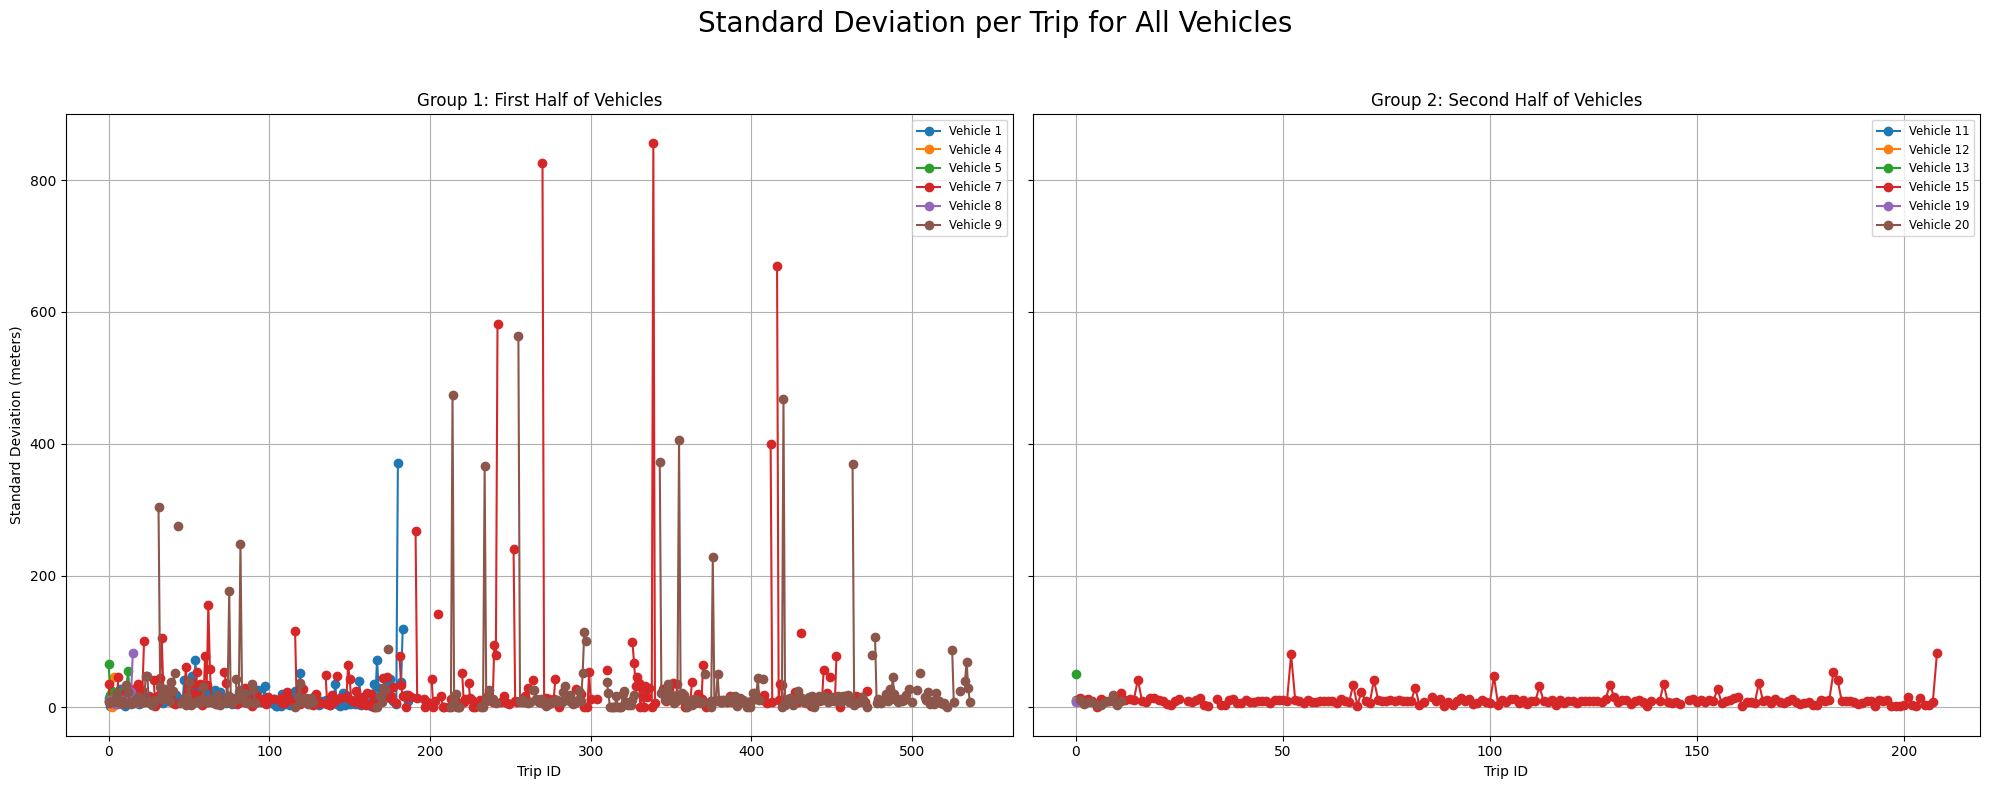

In [14]:
"""
This cell calculates and visualizes the standard deviation of GPS point-to-point distances (`distance_m`)
for each trip, grouped by `vehicleId` and `trip_id`, to analyze driving variability:

1. Groups the data by `vehicleId` and `trip_id`, then calculates the standard deviation of `distance_m`.
2. Renames the resulting column to `std_trip` for clarity.
3. Splits the vehicles into two groups:
    - `vehicles_group1`: First half of the unique vehicles.
    - `vehicles_group2`: Second half.
4. Creates two subplots (side-by-side) for better visual separation:
    - Each line represents one vehicle, showing how the standard deviation changes per trip.
5. Adds gridlines, legends, labels, and an overall title for clarity.
6. Saves the final plot to a predefined path (`PLOT_FOLDER_PATH`).
"""


# Calculate standard deviation per trip and vehicle
std_per_trip = merged_dfs.groupby(['vehicleId', 'trip_id'])['distance_m'].std().reset_index()
std_per_trip.rename(columns={'distance_m': 'std_trip'}, inplace=True)

# Get all unique vehicles
all_vehicles = std_per_trip['vehicleId'].unique()
mid_point = len(all_vehicles) // 2
vehicles_group1 = all_vehicles[:mid_point]
vehicles_group2 = all_vehicles[mid_point:]

# Set up 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot for first group
for vehicle in vehicles_group1:
    vehicle_data = std_per_trip[std_per_trip['vehicleId'] == vehicle]
    axes[0].plot(vehicle_data['trip_id'], vehicle_data['std_trip'], marker='o', label=f'Vehicle {vehicle}')

axes[0].set_title('Group 1: First Half of Vehicles')
axes[0].set_xlabel('Trip ID')
axes[0].set_ylabel('Standard Deviation (meters)')
axes[0].legend(fontsize="small")
axes[0].grid(True)

# Plot for second group
for vehicle in vehicles_group2:
    vehicle_data = std_per_trip[std_per_trip['vehicleId'] == vehicle]
    axes[1].plot(vehicle_data['trip_id'], vehicle_data['std_trip'], marker='o', label=f'Vehicle {vehicle}')

axes[1].set_title('Group 2: Second Half of Vehicles')
axes[1].set_xlabel('Trip ID')
axes[1].legend(fontsize="small")
axes[1].grid(True)

# Overall title
plt.suptitle('Standard Deviation per Trip for All Vehicles', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save plot
plt.savefig(f"{PLOT_FOLDER_PATH}Standard_Deviation_per_Trip_For_All_Vehicles.png")
plt.show()


#### Find the mean distance in all data

In [15]:
"""
Filters the dataset to exclude rows where the distance between consecutive GPS points is zero (`distance_m == 0.0`),
then computes and prints the mean distance traveled between valid points:

1. Filters `merged_dfs` to remove rows with `distance_m` equal to 0.0 (e.g., new trips or vehicles).
2. Calculates the mean of the remaining `distance_m` values.
3. Prints the computed mean distance to summarize average movement between valid GPS points.
"""


# Filter out rows where distance_m is 0.0
filtered_dfs = merged_dfs[merged_dfs['distance_m'] != 0.0]

# Find the mean distance across all data
mean_distance_nonzero = filtered_dfs['distance_m'].mean()

# Print the result
print(f"The mean distance (excluding 0.0) is: {mean_distance_nonzero}")


The mean distance (excluding 0.0) is: 20.925952624652727


### Plot all trips of all vehicles

/tmp/ipykernel_9889/531951968.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', num_vehicles)  # Choose a colormap with sufficient colors


Plot saved to ./Plots/all_trips_per_vehicle.png


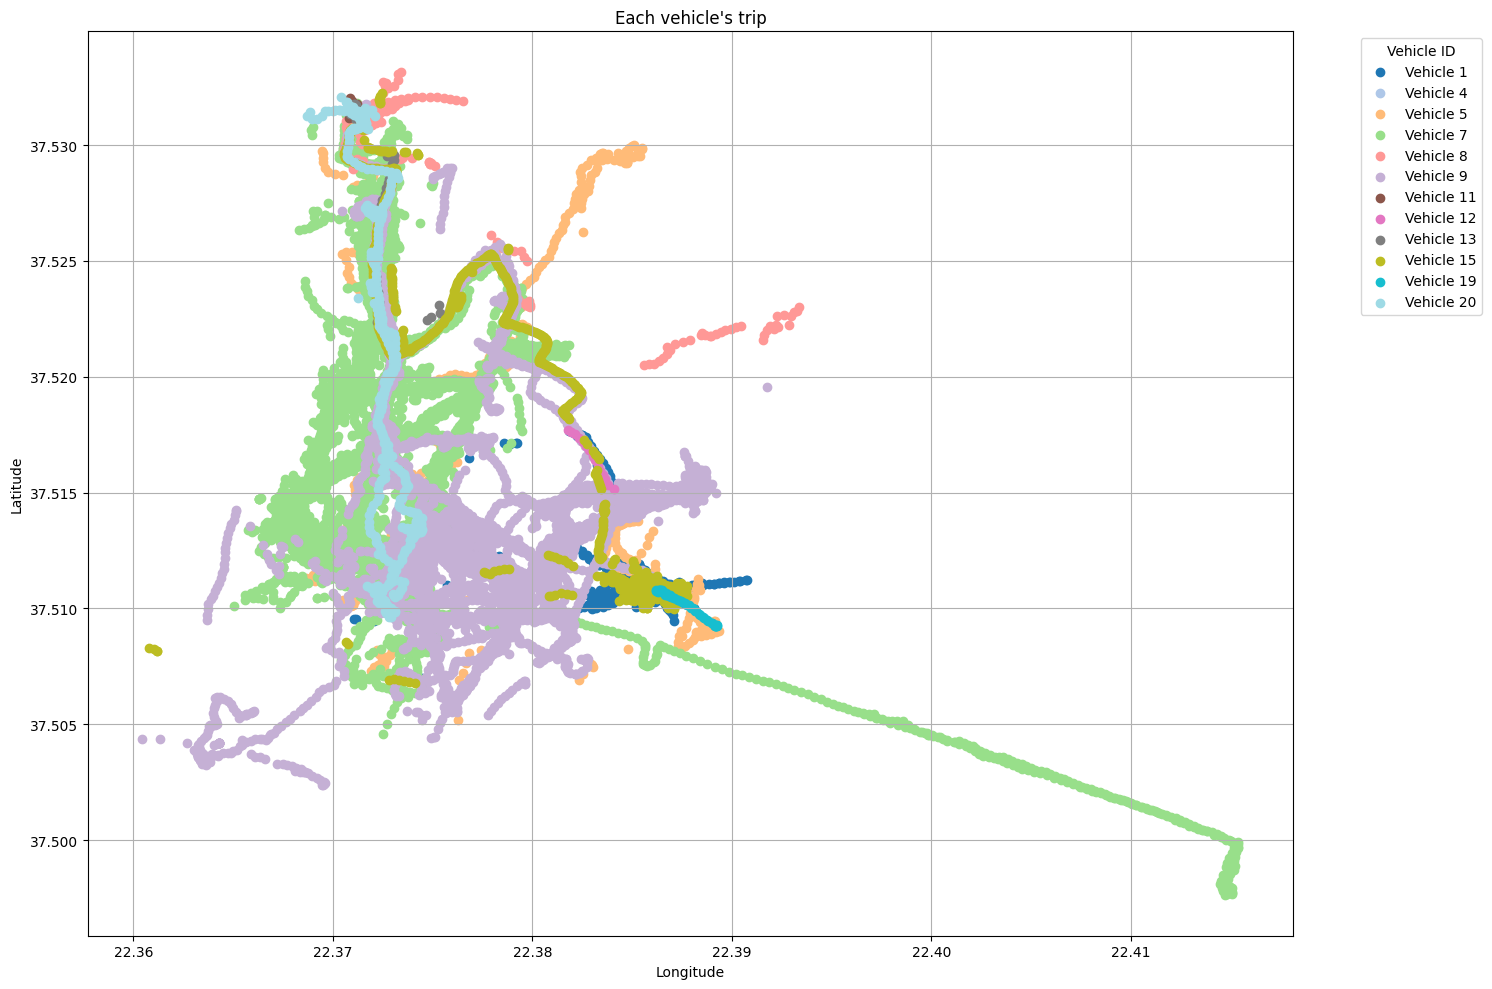

In [16]:
"""
Visualize the GPS points of all trips made by each vehicle on a scatter plot.

- Retrieves unique vehicle IDs and assigns a unique color to each.
- For each vehicle, filters the dataset and plots all its latitude-longitude points.
- Adds axis labels, title, legend (positioned outside the main plot), and a grid.
- Saves the resulting figure to the specified path as 'all_trips_per_vehicle.png'.
"""


# Generate a list of unique vehicle IDs
vehicle_ids = merged_dfs['vehicleId'].unique()  # Get unique vehicle IDs from merged_dfs
num_vehicles = len(vehicle_ids)
colors = cm.get_cmap('tab20', num_vehicles)  # Choose a colormap with sufficient colors

# Plot the data
plt.figure(figsize=(15, 10))
plt.title('Each vehicle\'s trip')

# Iterate through the unique vehicle IDs
for i, vehicle_id in enumerate(vehicle_ids):
    # Filter the data for each vehicle ID
    vehicle_data = merged_dfs[merged_dfs['vehicleId'] == vehicle_id]
    
    # Assign a color for each vehicle
    color = colors(i)
    
    # Plot the data for the current vehicle
    plt.scatter(vehicle_data['lng'], vehicle_data['lat'], label=f'Vehicle {vehicle_id}', color=color)

# Plot formatting
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Add legend outside the plot
plt.tight_layout()

# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "all_trips_per_vehicle.png")

# Save the plot
plt.savefig(plot_save_path, bbox_inches='tight')
print(f"Plot saved to {plot_save_path}")

# Show the plot (optional, can be removed if not needed)
plt.show()


### Plot velocity

#### 5️⃣ KDE Plot (Smooth Distribution)

#### What Does "Density" Stand For?

In **statistics and data visualization**, "density" refers to how frequently data points appear in a given range. Instead of showing counts (like a histogram), **density plots estimate the probability distribution** of the data.

- **Higher density (taller peaks)** means more data points are in that range.
- **Lower density (shorter peaks)** means fewer data points are in that range.

For example:
- A **histogram** shows how many data points fall into specific bins.
- A **KDE plot (Kernel Density Estimate)** smooths the histogram to show a continuous probability distribution.


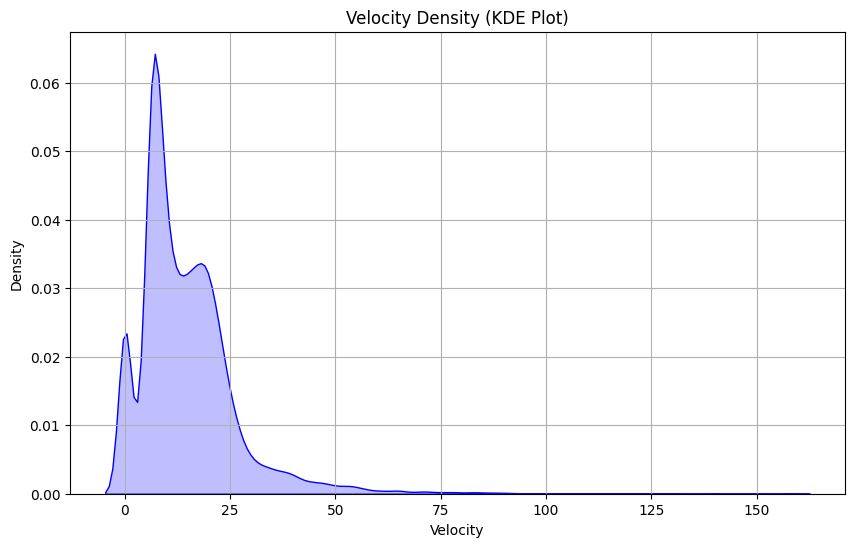

Total rows processed: 29032


In [17]:
"""
Generate and save a Kernel Density Estimate (KDE) plot for vehicle velocities.

- Flattens the 'velocity' column from the DataFrame into a list.
- Uses Seaborn to create a KDE plot that visualizes the distribution of velocity values.
- Adds labels, title, and grid for clarity.
- Saves the plot as 'velocity_density_kde_plot.png' in the specified plot folder.
- Displays the total number of rows (data points) processed for context.
"""


# Flatten the velocity data
all_velocities = merged_dfs['velocity'].tolist() 


total_lines = len(merged_dfs)

# Create the plot
plt.figure(figsize=(10, 6))
plt.title(f'Velocity Density (KDE Plot)')
plt.xlabel('Velocity')

# Plot the KDE (Kernel Density Estimate)
sns.kdeplot(all_velocities, fill=True, color='b')  

plt.grid(True)

# Define the path to save the plot
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "velocity_density_kde_plot.png")

# Save the plot
plt.savefig(plot_save_path)

# Show the plot
plt.show()

# Print the number of rows processed
print(f"Total rows processed: {total_lines}")


### Create orientations
- Calculate which the **30 degrees turns** on coordinatess
- Add <u>**orientation column for the 30 degrees turns</u>** to corresponding coordinates
- Plot the **30 degrees turns** vs velocities **before and after** making the turn

In [23]:
"""
Process coordinates and add bearing and orientation data to the DataFrame.

1. process_coordinates: 
    - Converts the merged DataFrame into a GeoDataFrame using latitude and longitude columns.
    - Defines two functions:
        - calculate_bearing: Calculates the bearing (direction) between two geographic points.
        - get_orientation: Converts a bearing into one of eight cardinal directions (e.g., North, East, etc.).
    - Identifies the latest coordinate and calculates the bearing and orientation between consecutive points.
    - Prints the latest coordinate and the next coordinates with their bearings and orientations.

2. add_bearing_and_orientation_columns: 
    - Calculates the bearing and orientation for each consecutive pair of coordinates in the DataFrame.
    - Adds new columns (bearing, orientation) to the DataFrame to store the calculated values.
    - The last row in the DataFrame is assigned None for bearing and an empty string for orientation as it has no next point to calculate.

Finally, it processes the data and prints the updated DataFrame with bearing and orientation information.

Returns:
    - latest_coordinate: The last coordinate in the DataFrame.
    - next_coordinates: A list of tuples containing current and next coordinates along with their bearings and orientations.
    - The merged_dfs DataFrame with added bearing and orientation columns.
"""


def process_coordinates(merged_dfs):
    gmerged_dfs = gpd.GeoDataFrame(merged_dfs, geometry=gpd.points_from_xy(merged_dfs['lng'], merged_dfs['lat']))
    
    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
        
        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        return (math.degrees(bearing) + 360) % 360  
    
    def get_orientation(bearing):
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        return directions[round(bearing / 45) % 8]
    
    def get_latest_and_next_coordinates(gmerged_dfs):
        latest_coordinate = gmerged_dfs.iloc[-1]  
        next_coordinates = []
        
        for idx in range(len(gmerged_dfs) - 1):
            current_row = gmerged_dfs.iloc[idx]
            next_row = gmerged_dfs.iloc[idx + 1]
            bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
            orientation = get_orientation(bearing)
            next_coordinates.append((current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'], bearing, orientation))
        
        return latest_coordinate, next_coordinates
    
    latest_coordinate, next_coordinates = get_latest_and_next_coordinates(gmerged_dfs)
    
    # print(Fore.YELLOW + "\nLatest Coordinate:" + Style.RESET_ALL)
    # print(latest_coordinate[['lat', 'lng']])
    
    print(Fore.YELLOW + "\nNext Coordinates with Orientation:" + Style.RESET_ALL)
    for coord in next_coordinates:
        # print(f"Current: ({coord[0]}, {coord[1]}) -> Next: ({coord[2]}, {coord[3]}) | Bearing: {coord[4]:.2f}° | Orientation: {coord[5]}")
    
    return latest_coordinate, next_coordinates

def add_bearing_and_orientation_columns(merged_dfs):
    def calculate_bearing(lat1, lon1, lat2, lon2):
        lat1_rad, lon1_rad = math.radians(lat1), math.radians(lon1)
        lat2_rad, lon2_rad = math.radians(lat2), math.radians(lon2)
        
        delta_lon = lon2_rad - lon1_rad
        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        bearing = math.atan2(x, y)
        return (math.degrees(bearing) + 360) % 360  
    
    def get_orientation(bearing):
        directions = ['North', 'Northeast', 'East', 'Southeast', 'South', 'Southwest', 'West', 'Northwest']
        return directions[round(bearing / 45) % 8]
    
    bearings = []
    orientations = []
    
    for idx in range(len(merged_dfs) - 1):
        current_row = merged_dfs.iloc[idx]
        next_row = merged_dfs.iloc[idx + 1]
        bearing = calculate_bearing(current_row['lat'], current_row['lng'], next_row['lat'], next_row['lng'])
        orientation = get_orientation(bearing)
        
        bearings.append(bearing)
        orientations.append(orientation)
    
    bearings.append(None)  # Last row has no next point, so bearing is None
    orientations.append("")  
    
    merged_dfs['bearing'] = bearings
    merged_dfs['orientation'] = orientations
    
    return merged_dfs

latest_coordinate, next_coordinates = process_coordinates(merged_dfs)
merged_dfs = add_bearing_and_orientation_columns(merged_dfs)

print(Fore.YELLOW + "Updated DataFrame:" + Style.RESET_ALL)
# print(merged_dfs.head())
print("Finished")

TypeError: 'ellipsis' object is not subscriptable

#### Calculate Bearing diff

In [ ]:

def calculate_bearing_difference(df):
    """
    Calculates the absolute difference between consecutive bearing values within each trip_id.
    
    Parameters:
        df (pd.DataFrame): A DataFrame containing 'trip_id' and 'bearing' columns.
        
    Returns:
        pd.DataFrame: DataFrame with a new column 'bearing_diff'.
    """
    if 'bearing' not in df.columns or df.empty:
        return df

    def compute_bearing_diff(group):
        group = group.copy()
        group['bearing_diff'] = group['bearing'].diff().abs().fillna(0.0)
        return group

    df = df.groupby('trip_id', group_keys=False).apply(compute_bearing_diff)
    df['bearing_diff'] = df['bearing_diff'].round(2)

    # Fix potential weird index issue from groupby().apply()
    return df.reset_index(drop=True)


merged_dfs = calculate_bearing_difference(merged_dfs)
print(merged_dfs.columns)  # 'bearing_diff' should now exist


## Plot **velocities on coordinates**

In [ ]:
"""
Generates and saves a scatter plot of vehicle positions using longitude and latitude,
colored by velocity. The plot includes grid lines, axis labels, a colorbar, and is
saved to the specified plot folder.

Assumes `merged_dfs` contains 'lng', 'lat', and 'velocity' columns.
"""

plt.figure(figsize=(20, 10))
plt.title('Velocities on Coordinates')
plt.xlabel('Longitude')  # Corrected label
plt.ylabel('Latitude')   # Corrected label
plt.grid()

# Plot the scatter plot with velocity as the color
scatter = plt.scatter(
    merged_dfs['lng'],  # Longitude on X-axis
    merged_dfs['lat'],  # Latitude on Y-axis
    c=merged_dfs['velocity'], 
    cmap='viridis', 
    s=100, 
    edgecolors='k'  # Ensure this matches the marker style
)

# Add color bar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Velocities')

plt.tight_layout()

# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}velocities_on_coordinates_scatter.png")

plt.show()


## Data **Cleaning**

### Filter **noise velocties** (>=51)

In [ ]:
"""
Calculates and prints the number and percentage of rows in `merged_dfs` where the 'velocity'
exceeds a defined noise threshold (`NOISE_VELOCITIES`). Outputs the total row count, the
count of high-velocity rows, and their percentage.
"""

NOISE_VELOCITIES = 60
count_noise_vel = (merged_dfs['velocity'] > NOISE_VELOCITIES).sum()  # Count the rows where 'velocity' >= 51
total_rows = len(merged_dfs)  # Total number of rows in the DataFrame

# Calculate the percentage
percentage = (count_noise_vel / total_rows) * 100

# Print the results
print(f"Total # of lines of DataSet: {total_rows}")
print(f"Num of velocities >= {NOISE_VELOCITIES}: {count_noise_vel}")
print(Fore.YELLOW + f"Percentage of velocities >= {NOISE_VELOCITIES}: {percentage:.2f}%"+ Style.RESET_ALL)


### Plot percentage of **noise velocities**

In [ ]:
"""
Creates and saves a pie chart visualizing the distribution of velocities in `merged_dfs`
relative to a defined threshold (`NOISE_VELOCITIES`). Displays the proportion of velocities
above and below the threshold, with labels, colors, and an emphasized high-velocity slice.
"""

count_noise_vel = (merged_dfs['velocity'] > NOISE_VELOCITIES).sum()
total_rows = len(merged_dfs)
percentage = (count_noise_vel / total_rows) * 100

labels = ['Velocities ≤ 60 km/h', 'Velocities ≥ 61 km/h']
sizes = [total_rows - count_noise_vel, count_noise_vel]
colors = ['#66b3ff', '#ff6666']
explode = (0, 0.1)

# Δημιουργία διαγράμματος
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct='%1.1f%%', shadow=True, startangle=140)
ax.axis('equal')
plt.title(f'Distribution of Velocities\n(Threshold: {NOISE_VELOCITIES} km/h)')

# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Distribution_of_Velocitieses_scatter_inside_Tripoli's_BOX.png")

plt.show()


### Calculate percentage of Tripoli's BBOX data in comparison with all data

In [ ]:
"""
Filters `merged_dfs` to identify rows within the Tripoli bounding box defined by `tripoli_bbox`,
calculates the percentage of such rows, and prints the result in green if 100%, otherwise in red.
"""

# Extract bounding box coordinates from the dictionary
latMin = tripoli_bbox['latMin']
latMax = tripoli_bbox['latMax']
lngMin = tripoli_bbox['lngMin']
lngMax = tripoli_bbox['lngMax']

# Filter rows that are within the bounding box
in_bbox = merged_dfs[(merged_dfs['lat'] >= latMin) & (merged_dfs['lat'] <= latMax) &
                     (merged_dfs['lng'] >= lngMin) & (merged_dfs['lng'] <= lngMax)]

# Calculate the percentage of rows in the bounding box
percentage_in_bbox = (len(in_bbox) / len(merged_dfs)) * 100

# Change the color based on the percentage
color = Fore.GREEN if percentage_in_bbox == 100 else Fore.RED

# Print the result with the selected color
print(color + f"Percentage of rows inside the bounding box: {percentage_in_bbox:.2f}%" + Style.RESET_ALL)



### Get velocity data and vehicle IDs for rows within specified **BBOX**

In [ ]:
def get_velocity_in_area(df, bbox):
    """
    Get velocity data and vehicle IDs for rows within specified latitude and longitude bounds.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        bbox (dict): The bounding box coordinates containing latMin, latMax, lngMin, lngMax.

    Returns:
        pd.DataFrame: A DataFrame containing 'vehicleId' and 'velocity' within the specified area.
    """
    try:
        # Extract bounding box coordinates from the dictionary
        latMin, latMax = bbox['latMin'], bbox['latMax']
        lngMin, lngMax = bbox['lngMin'], bbox['lngMax']
        
        # Filter rows based on latitude and longitude ranges
        filtered_df = df[
            (df['lat'] >= latMin) & (df['lat'] <= latMax) &
            (df['lng'] >= lngMin) & (df['lng'] <= lngMax)
        ]
        
        # Return the subset of DataFrame with 'vehicleId' and 'velocity' columns
        return filtered_df[['vehicleId', 'velocity']]

    except KeyError as e:
        print(f"Error: Missing required column: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return pd.DataFrame(columns=['vehicleId', 'velocity'])


# Assuming the tripoli_bbox dictionary is already defined
# Get filtered velocities using the tripoli_bbox dictionary
BBOX_df = get_velocity_in_area(merged_dfs, tripoli_bbox)

# Optionally, print the result
print(BBOX_df.head())


In [ ]:
merged_dfs.dtypes

## Calculate **Acceleration**

In [ ]:
"""
Calculates the velocity difference between consecutive rows and computes the acceleration based on
velocity change and time difference. Resets acceleration to 0.0 when there is a change in `vehicleId`
or `trip_id`, and handles any NaN values in the `acceleration` column (e.g., due to missing data).

Assumes `merged_dfs` contains 'velocity', 'seconds_diff', 'vehicleId', and 'trip_id' columns.
"""

# Compute velocity difference between consecutive rows
merged_dfs['velocity_diff'] = merged_dfs['velocity'].diff().fillna(0.0)

# Compute acceleration: velocity change / time change
merged_dfs['acceleration'] = (merged_dfs['velocity_diff'] * (1000/3600)) / merged_dfs['seconds_diff']

# Reset acceleration to 0.0 when either vehicleId or trip_id changes
merged_dfs.loc[(merged_dfs['vehicleId'].diff() != 0) | (merged_dfs['trip_id'].diff() != 0), 'acceleration'] = 0.0

# Handle NaN values (e.g., first row, or division by zero)
merged_dfs['acceleration'] = merged_dfs['acceleration'].fillna(0.0)

### Plot Acceleration **stats**

In [ ]:
"""
Groups `merged_dfs` by `vehicleId` and `trip_id`, calculates the standard deviation and variance
of acceleration for each group, and then creates a boxplot visualizing the standard deviation of
acceleration per vehicle.

Assumes `merged_dfs` contains 'vehicleId', 'trip_id', and 'acceleration' columns.
"""

# Group by vehicleId και trip_id και υπολόγισε std & var της επιτάχυνσης
accel_stats = merged_dfs.groupby(['vehicleId', 'trip_id'])['acceleration'].agg(['std', 'var']).reset_index()
# Group by vehicleId και trip_id και υπολόγισε std & var της επιτάχυνσης
accel_stats = merged_dfs.groupby(['vehicleId', 'trip_id'])['acceleration'].agg(['std', 'var']).reset_index()


plt.figure(figsize=(12, 6))

# Boxplot: τυπική απόκλιση επιτάχυνσης ανά όχημα
accel_stats.boxplot(column='std', by='vehicleId', grid=False, showfliers=False)

plt.title('Distribution of Acceleration STD per Vehicle (Grouped by Trip)')
plt.suptitle('')
plt.xlabel('Vehicle ID')
plt.ylabel('Standard Deviation of Acceleration (m/s²)')


# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Standard_Deviationof_Acceleration.png")
plt.show()

### Avergae Acceleration STD per vehicleId

In [ ]:
"""
Calculates the mean standard deviation of acceleration per vehicle and creates a bar plot
to visualize the average acceleration standard deviation for each vehicle.

Assumes `accel_stats` contains 'vehicleId' and 'std' columns.
"""

mean_std_per_vehicle = accel_stats.groupby('vehicleId')['std'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(mean_std_per_vehicle['vehicleId'].astype(str), mean_std_per_vehicle['std'], color='#66b3ff')
plt.title('Average Acceleration STD per Vehicle')
plt.xlabel('Vehicle ID')
plt.ylabel('Mean Standard Deviation of Acceleration (m/s²)')
plt.tight_layout()


# Save the plot
plt.savefig(f"{PLOT_FOLDER_PATH}Barplot_Mean_Acceleration_STD_per_Vehicle.png")
plt.show()

### Plot Acceleration 

In [ ]:
"""
Removes the 'index' column from `merged_dfs` if it exists, then plots the acceleration values
over time (using the DataFrame's index as the x-axis). The plot is saved and displayed.

Assumes `merged_dfs` contains 'acceleration' column.
"""

# Drop the 'index' column if it exists
if 'index' in merged_dfs.columns:
    merged_dfs.drop(columns=['index'], inplace=True)

# Extract x and y values
x = merged_dfs.index.values  # Use the DataFrame's index as x-axis
y = merged_dfs['acceleration'].values  # Acceleration values

# Plot acceleration
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='None', color='r')
plt.title('Acceleration Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (m/s^2)')
plt.grid(True)
plt.tight_layout()

# Save the filtered plot
plt.savefig(f"{PLOT_FOLDER_PATH}velocities_on_coordinates_scatter_filtered.png")
plt.show()  # Display the plot


### Plot Rate of data logging

In [ ]:
"""
Filters `merged_dfs` for a specific vehicle (`vehicleId = 1`), calculates the time differences 
between consecutive records, and plots the irregular data logging rate over time.

Assumes `merged_dfs` contains 'dateStoredHuman' and 'vehicleId' columns.
"""

df = merged_dfs.copy()

df["timestamp"] = pd.to_datetime(df["dateStoredHuman"])

# Filter data only for vehicleId = 1 (only for example)
df_vehicle = df[df["vehicleId"] == 1]

# Sort data by timestamp
df_vehicle = df_vehicle.sort_values("timestamp").reset_index(drop=True)

# Calculate the time difference between consecutive records
df_vehicle["time_diff"] = df_vehicle["timestamp"].diff().dt.total_seconds()

# Plot time intervals between records
plt.figure(figsize=(10,5))
plt.plot(df_vehicle["timestamp"][1:], df_vehicle["time_diff"][1:], marker='o', linestyle='-', color='b')
plt.xlabel("Timestamp")
plt.ylabel("Time interval between records (seconds)")
plt.title("Irregular Data Logging Rate")
plt.grid()
# Save the filtered plot
plt.savefig(f"{PLOT_FOLDER_PATH}rate_of_data_logging")
plt.show()


### Filter problematic **accelerations** (< -0.50)

In [ ]:
merged_dfs["isProblem"] = merged_dfs["acceleration"].apply(lambda x: 1 if x < -0.50 else 0) #! isProblem: 1 == False, 0 == True

print(merged_dfs)

# Save DF to **csv**

In [ ]:
"""
Saves the `merged_dfs` DataFrame to a CSV file at the specified path (`all_vehicles_data_path`),
and prints a confirmation message with the file path.

Assumes `merged_dfs` is a DataFrame.
"""

all_vehicles_data_path = "../../DataSets/API_Responses/Vehicle_Data/all_vehicle_responses.csv"
merged_dfs.to_csv(all_vehicles_data_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {all_vehicles_data_path}" + Style.RESET_ALL)

# Create a dict of all vehcileId converted to DF

In [ ]:
# Method to create unique vehicle dataframes
def create_vehicle_dfs(df: pd.DataFrame) -> dict:
    """
    Create a dictionary of DataFrames, one for each unique vehicleId.

    Args:
        df (pd.DataFrame): The input DataFrame containing a column `vehicleId` to filter by.

    Returns:
        dict: A dictionary where each key is a unique `vehicleId` and each value is a DataFrame 
            containing all rows for that `vehicleId`.
    """
    vehicle_dfs = {}
    # Loop through each unique vehicleId in the DataFrame
    for vehicle_id in df['vehicleId'].unique():
        vehicle_dfs[vehicle_id] = df[df['vehicleId'] == vehicle_id]
    return vehicle_dfs

# Call the function with your merged_df
vehicle_dfs = create_vehicle_dfs(merged_dfs)

# Print all vehicleIds
print("All vehicle IDs:")
for vehicle_id in vehicle_dfs.keys():
    print(vehicle_id)


#Print the DataFrame for that vehicleId
print(vehicle_dfs[4])





In [ ]:
a =

## Convert to GeoJson and save them

In [ ]:
def save_vehicle_geojson_csvs(vehicle_dfs: dict, output_path: str = "../../DataSets/GeoJSON/") -> None:
    """
    Converts each vehicle-specific DataFrame in the dictionary into GeoJSON-compatible format
    and saves them as CSV files usable by ArcGIS Online.

    Parameters:
        vehicle_dfs (dict): Dictionary where keys are vehicle IDs and values are DataFrames
                            containing at least 'lat' and 'lng' columns.
        output_path (str): Directory where the CSV files will be saved.
    """

    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)

    for vehicle_id, df in vehicle_dfs.items():
        if df.empty:
            print(f"Skipping vehicle ID {vehicle_id}: empty DataFrame.")
            continue

        if not {'lat', 'lng'}.issubset(df.columns):
            print(f"Skipping vehicle ID {vehicle_id}: missing 'lat' or 'lng' columns.")
            continue

        # Copy DataFrame and add GeoJSON geometry column
        df = df.copy()
        df['geometry'] = df.apply(lambda row: json.dumps({
            "type": "Point",
            "coordinates": [row['lng'], row['lat']]
        }), axis=1)

        # Define filename and save CSV
        filename = f"vehicle_{vehicle_id}.csv"
        file_path = os.path.join(output_path, filename)
        df.to_csv(file_path, index=False)

        print(f"Vehicle ID {vehicle_id} saved to {file_path}")


save_vehicle_geojson_csvs(vehicle_dfs)


### Create a method that extracts to **GeoJSON selected vehicle, trip IDs**

# **Update** DB

In [ ]:
from pymongo import MongoClient
from colorama import Fore, Style
import datetime
import numpy as np

def convert_mongo_safe(val):
    """Converts values to MongoDB-compatible types."""
    if hasattr(val, "item"):
        return val.item()  # Convert numpy types to native Python types
    elif isinstance(val, datetime.date) and not isinstance(val, datetime.datetime):
        return datetime.datetime(val.year, val.month, val.day)  # Convert datetime.date to datetime.datetime
    elif isinstance(val, datetime.time):
        return val.strftime("%H:%M:%S")  # Convert datetime.time to a string format
    return val

def upsert_vehicle_data_to_mongodb(vehicle_dfs: dict, mongo_uri: str = "mongodb://localhost:27017/", 
                                   db_name: str = "Ptyxiaki", collection_name: str = "Unique_Vehicles") -> None:
    """
    Inserts or updates vehicle-specific data into a MongoDB collection from a dictionary of DataFrames.

    Converts unsupported types (NumPy, datetime.date, datetime.time) to MongoDB-compatible formats.

    Parameters:
        vehicle_dfs (dict): Dict of DataFrames keyed by vehicleId.
        mongo_uri (str): MongoDB connection string.
        db_name (str): Target database name.
        collection_name (str): Target collection name.
    """
    client = MongoClient(mongo_uri)
    db = client[db_name]
    collection = db[collection_name]

    for vehicle_id, df in vehicle_dfs.items():
        if df.empty:
            print(Fore.YELLOW + f"Skipping vehicle ID {vehicle_id}: empty DataFrame." + Style.RESET_ALL)
            continue

        # Use applymap() with .apply() on the DataFrame to convert each cell value
        df_clean = df.apply(lambda x: x.apply(convert_mongo_safe) if x.ndim == 1 else x)

        vehicle_data = df_clean.to_dict(orient="records")

        collection.replace_one(
            {"vehicleId": int(vehicle_id)},
            {"vehicleId": int(vehicle_id), "data": vehicle_data},
            upsert=True
        )
        print(Fore.GREEN + f"Vehicle ID {vehicle_id} inserted/updated in MongoDB." + Style.RESET_ALL)

# Example usage:
upsert_vehicle_data_to_mongodb(vehicle_dfs)

# **Get data from Overpass API**

In [ ]:
tripoli_bbox = {
    'latMin': 37.49764419371479,
    'latMax': 37.56244081620044,
    'lngMin': 22.344992459074458,
    'lngMax': 22.521463853839485
}

# MongoDB connection
client = MongoClient("mongodb://localhost:27017/")  # Adjust for your MongoDB URI
db = client["Ptyxiaki"]  # Replace with your database name
collection = db["Tripoli's_Roads"]  # Replace with your collection name

# Overpass API endpoint
url = "https://overpass-api.de/api/interpreter"

# Extract bounding box coordinates from tripoli_bbox dictionary
latMin, latMax = tripoli_bbox['latMin'], tripoli_bbox['latMax']
lngMin, lngMax = tripoli_bbox['lngMin'], tripoli_bbox['lngMax']

# Check if collection is empty
if collection.count_documents({}) == 0:
    print(Fore.YELLOW + "Collection is empty. Fetching data from Overpass API..." + Style.RESET_ALL)

    # Overpass QL query to get all types of roads within the bounding box
    query = f"""
    [out:json];
    (
      way({latMin},{lngMin},{latMax},{lngMax})["highway"];
    );
    out geom;
    """

    # Make request to Overpass API
    response = requests.post(url, data=query)

    # Check if the response status is OK (status code 200)
    if response.status_code == 200:
        try:
            # Try to parse the JSON response
            osm_data = response.json()
            elements = osm_data.get("elements", [])

            # Extract relevant data
            named_streets_data = []
            for element in elements:
                tags = element.get("tags", {})
                if 'name' in tags:
                    # Convert string representation of coordinates to list
                    coords_str = element.get("geometry", [])
                    named_streets_data.append([
                        element["id"],
                        "way",
                        tags.get('name', 'Unnamed Street'),
                        tags.get('highway', None),
                        tags.get('name', None),
                        coords_str
                    ])

            # Convert to DataFrame
            df_named_streets = pd.DataFrame(named_streets_data, columns=["id", "type", "name", "highway", "name_en", "coordinates"])

            # Sort the DataFrame by the 'name' column (alphabetically)
            df_named_streets = df_named_streets.sort_values(by='name')

            # Group by the 'name' column and merge coordinates
            df_grouped = df_named_streets.groupby('name').agg({
                'id': 'first',  # Keep the first ID for the road
                'type': 'first',  # Keep the first type (way)
                'highway': 'first',  # Keep the first highway type
                'name_en': 'first',  # Keep the first name_en
                'coordinates': lambda x: sum(x, [])  # Merge all coordinates into one list
            }).reset_index()

            # Convert grouped DataFrame to dictionary and insert it into MongoDB
            collection.insert_many(df_grouped.to_dict('records'))

            print(Fore.GREEN + f"Grouped streets data fetched and saved to MongoDB." + Style.RESET_ALL)

        except ValueError as e:
            # Handle JSON parsing errors
            print(f"Error parsing JSON response: {e}")
    else:
        print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")
        print("Response Text: ", response.text)
else:
    print("Data already exists in the collection. Skipping API request.")



# Create GEOJSON format

In [ ]:
# Initialize the necessary class
ArcGIS_road_creator = RoadGeoJSONCreator()

# Function to get road data in dictionary format
def get_road_data(road_name):
    """Retrieves road data from DataFrame in dictionary format."""
    filtered_data = df_named_streets[df_named_streets['name'] == road_name]

    if not filtered_data.empty:
        for _, row in filtered_data.iterrows():
            coords = row["coordinates"]  # Get the coordinates from the DataFrame
            
            # Check if coordinates are already a list (which they should be)
            if isinstance(coords, list):
                # Coordinates are already a list, so no need for parsing
                road_data = {
                    "name": row["name"],
                    "highway": row["highway"],
                    "name_en": row["name_en"] if "name_en" in row else row["name"],  # Fallback to 'name' if no English name
                    "coordinates": [{"lat": coord['lat'], "lon": coord['lon']} for coord in coords],
                }
            else:
                print(f"Error: Coordinates for road '{road_name}' are not in the expected list format.")
                return None
            
            return road_data
    else:
        print(f"Road with name '{road_name}' not found.")
        return None

# Example usage
road_name_input = "Αλεξάνδρου-Σούτσου"
road_data = get_road_data(road_name_input)

# If road data exists, convert to GeoJSON and save
if road_data:
    # Updated the directory to save the GeoJSON files in the new path
    directory = "../../DataSets/GeoJSON"
    os.makedirs(directory, exist_ok=True)  # Ensure the directory exists
    file_path = os.path.join(directory, f"{road_name_input.replace(' ', '_')}.geojson")
    
    # Check if the GeoJSON creator exists and is callable
    if hasattr(ArcGIS_road_creator, 'from_dict'):
        ArcGIS_road_creator.from_dict(road_data, file_path)
    else:
        print("GeoJSON Creator method 'from_dict' is not available.")
else:
    print("No road data to save.")
